<a href="https://colab.research.google.com/github/erobrien6/OBrien_DSPN_S23/blob/main/Exercise13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 13:  Resampling methods

This homework assignment is designed to give you practice with bootstrapping and permutation tests.

You will need to download the **unrestricted_trimmed_1_7_2020_10_50_44.csv** file from the *Homework/hcp_data* folder in the class GitHub repository. 

This data is a portion of the [Human Connectome Project database](http://www.humanconnectomeproject.org/). It provides measures of cognitive tasks and brain morphology measuresments from 1206 participants. The full description of each variable is provided in the **HCP_S1200_DataDictionary_April_20_2018.csv** file in the *Homework/hcp_data* folder in the class GitHub repository.

---
## 1. Loading & Visualizing the Data (1 point)

Use the `setwd` and `read.csv` functions to load data from the **unrestricted_trimmed_1_7_2020_10_50_44.csv** file. 

(a) Using the tidyverse tools, make a new dataframe `d1` that only inclues the subject ID (`Subject`), gender (`Gender`, self reported at time of data collection), Flanker Task performance (`Flanker_Unadj`), total intracranial volume (`FS_IntraCranial_Vol`), total white matter volume (`FS_Tot_WM_Vol`), and total grey matter volume (`FS_Total_GM_Vol`) variables and remove all _na_ values.

Use the `head` function to look at the first few rows of each data frame. 

In [2]:
# Load in Data
library(tidyverse)

df_raw <- read.csv("/content/unrestricted_trimmed_1_7_2020_10_50_44.csv")

df_brain <- df_raw %>%
  select(c('Subject', 'Gender', 'Flanker_Unadj', 'FS_IntraCranial_Vol', 
'FS_Tot_WM_Vol', 'FS_Total_GM_Vol'))

# Remove NAs
nrow(df_brain)
df_brain <- drop_na(df_brain)
nrow(df_brain) # Check that drop worked

head(df_brain)
dim(df_brain)



[1] 1206

[1] 1113

,Subject,Gender,Flanker_Unadj,FS_IntraCranial_Vol,FS_Tot_WM_Vol,FS_Total_GM_Vol
,<int>,<chr>,<dbl>,<dbl>,<int>,<int>
1,100206,M,130.42,1864518,543134,807245
2,100307,F,112.56,1512540,407292,664124
3,100408,M,121.18,1684117,500417,726206
4,100610,M,126.53,1816044,512946,762308
5,101006,F,101.85,1437868,429449,579632
6,101107,M,107.04,1512727,416995,665024


[1] 1113    6

(b) Plot grey matter volume (x axis) against intracranial volume (y axis) and Gender (point color). 

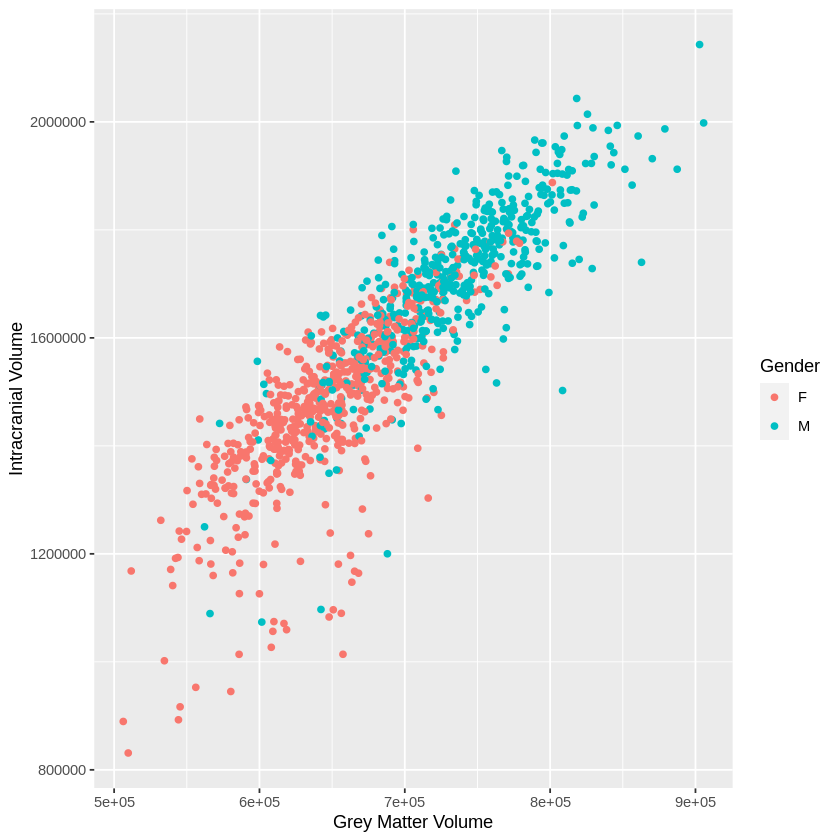

In [3]:
library(ggplot2)

ggplot(df_brain, aes(x=FS_Total_GM_Vol, y=FS_IntraCranial_Vol, col=Gender)) +
  geom_point() +
  xlab('Grey Matter Volume') +
  ylab('Intracranial Volume')



What patterns do you observe in the scatter plot?

> *It appears that, overall, there is a strong positive association between grey matter volume and intracranial volume in the plot. Men appear to fall on the higher end of both variables, whereas women tend to be clustered lower on both variables.* 
> 

---
## 2. Logistic classifier (2 points)

We want to try predicting gender using the neural data you have loaded.

(a) Run a logisic regression model to predict gender from total white matter volume, total grey matter volume, and intracranial volume. 

In [4]:
df_brain$Gender <- as.factor(df_brain$Gender)
log_model <- glm(Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol,
 data=df_brain, family=binomial)
summary(log_model)




Call:
glm(formula = Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol, 
    family = binomial, data = df_brain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7695  -0.6173  -0.1863   0.5997   3.2309  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -2.262e+01  1.347e+00 -16.787  < 2e-16 ***
FS_Tot_WM_Vol        2.140e-06  3.059e-06   0.699    0.484    
FS_Total_GM_Vol      1.959e-05  3.145e-06   6.229 4.70e-10 ***
FS_IntraCranial_Vol  5.020e-06  1.177e-06   4.263 2.01e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1534.13  on 1112  degrees of freedom
Residual deviance:  919.85  on 1109  degrees of freedom
AIC: 927.85

Number of Fisher Scoring iterations: 5


Which factors are signficantly associated with gender?

> *Total grey matter volume and intracranial volume are significantly associated with gender.* 
> 

(b) Estimate the prediction accuracy of your model (Note: this is the training set accuracy). Set your prediction threshold to 0.5.

In [8]:
# Predict
glm_prob_df = data.frame(predict(log_model, type = 'response'))
colnames(glm_prob_df) = c('Predicted_Prob')
total_n = nrow(glm_prob_df)
glm_prob_df$index = seq(1, total_n)


df_brain$Gender <- as.factor(df_brain$Gender)
contrasts(df_brain$Gender)

thresh = 0.5

# List of Incorrect
glm_prob_df$predicted_binary=rep("F", total_n)
glm_prob_df$predicted_binary[glm_prob_df$Predicted_Prob>thresh]="M"

# Confusion Matrix
confusion_df = data.frame(glm_prob_df$predicted_binary, df_brain$Gender)
colnames(confusion_df) = c('predicted', 'actual')

table(confusion_df)

print(paste("Accuracy:",mean(confusion_df$predicted == confusion_df$actual)))



,M
F,0
M,1


         actual
predicted   F   M
        F 516 110
        M  90 397

[1] "Accuracy: 0.820305480682839"


What is the prediction accuracy for gender from the full model?

>*0.820* 
> 

---
## 3. Bootstrapped accuracy (3 points)

Use bootstrapping to estimate the confidence intervals of the _prediction accuracy_ of your model (i.e., the confidence of the correlation between $\hat{y}$ and $y$). Plot the histogram of the bootstrapped prediction accuracies and estimate the confidence intervals off of the standard deviation from the bootstrap.


[1] 0.8203055

ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = df_brain, statistic = boot.fn, R = 1000)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.8203055 -0.002213836 0.004372746


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot_obj, conf = 0.95, type = "norm")

Intervals : 
Level      Normal        
95%   ( 0.8139,  0.8311 )  
Calculations and Intervals on Original Scale

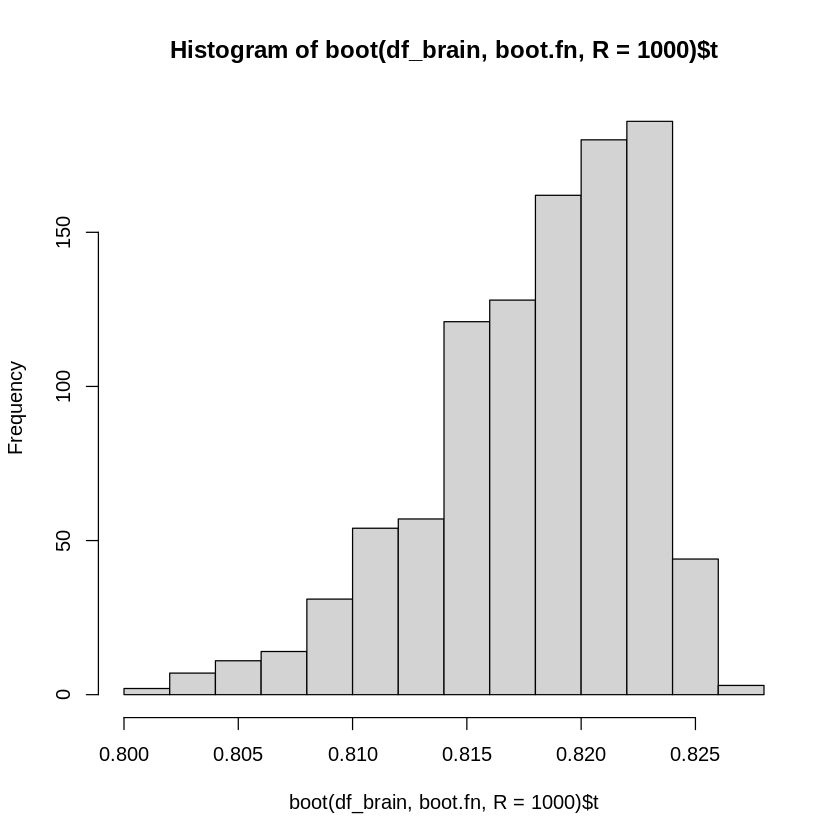

In [27]:
# install.packages("ISLR")
library(ISLR)
library(boot)

# The function needs two inputs: Data, Index
boot.fn <- function(data, index){  
      model1 <- glm(Gender~FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol, family = binomial, data=data, subset=index)
      p1 <- predict(model1, data, type="response")
      p2 <- rep("F", nrow(data))
      p2[p1 > 0.5] = "M"
      conf_boot = data.frame(p2, data$Gender)
      colnames(conf_boot) = c('predicted', 'actual')
      return(mean(conf_boot$predicted == conf_boot$actual))
    }
print(boot.fn(df_brain, 1:nrow(df_brain)))
boot_obj = boot(df_brain ,boot.fn ,R=1000) #R=repetitions 
print(boot_obj)
hist(boot(df_brain ,boot.fn ,R=1000)$t)


boot.ci(boot.out = boot_obj, conf = 0.95, type="norm")


How robust is the prediction accuracy of the full model?

> *The parametric and bootstrap estimates are very similar, which suggests that the prediction accuracy is robust for the full model. The 95% confidence interval indicates that our prediction accuracy of 0.82 is robust as well (95% CI: [0.81, 0.83]).  

---
## 4. Permutation test for grey matter effects (3 points)

Now run a permutation test, with 1000 iterations, to evaluate how much grey matter volume contributes to the prediction accuracy. Compare the prediction accuracy of the full (unpermuted model) with the distribution of accuracies you get with a randomized grey matter volume term using a histogram (Hint: use the `abline` function to show the original accuracy on the histogram).

[1] 0

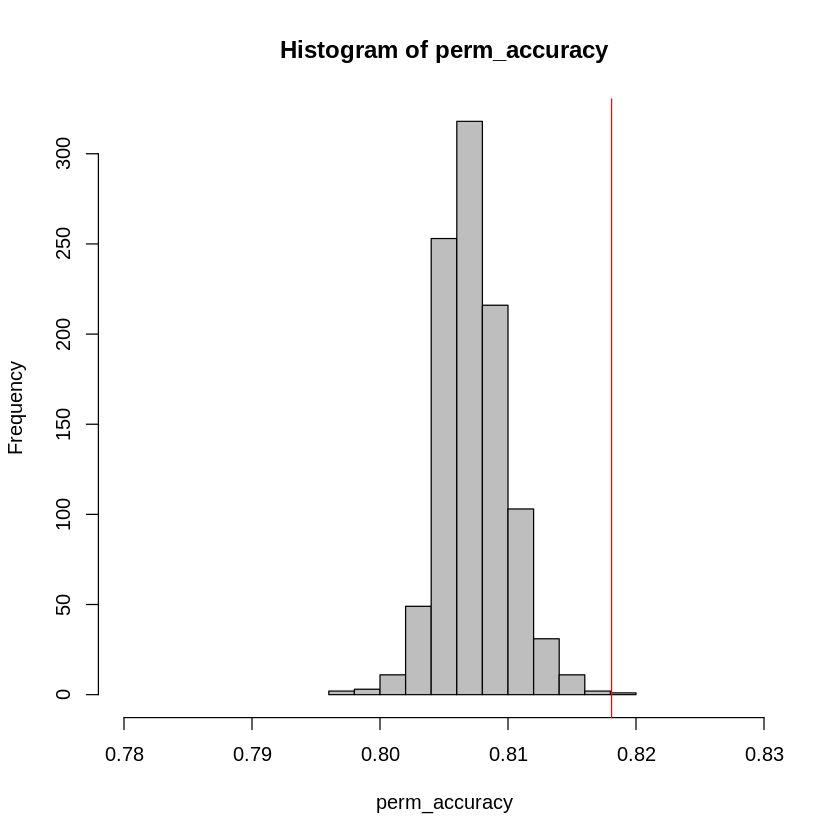

In [35]:
# First let's make a copy of the data set that we'll keep permuting
permBrain = df_brain #want to preserve the non-permuted, true form of data!

# Set the number of iterations
R=1000
n = dim(df_brain)[1]
perm_accuracy <- matrix(NA, nrow=R, ncol=1)

# Now just write a for loop where we scramble the observations
# in X using the sample() function. We'll scramble the observations in R different ways
for (i in 1:R){
  permBrain[,6] = permBrain[sample(n), 6] # Column 6 = Gray matter
  model_fit <- glm(Gender ~ ., data=permBrain, family=binomial)
  perm_predict = predict(model_fit, type="response")
  perm_prob <- ifelse(perm_predict > 0.5, "M", "F")
  perm_accuracy[i] = mean(perm_prob==permBrain[,2]) # Compare model outcome to what's in dataframe
}

# Null distributions
hist(perm_accuracy, col='gray', xlim=c(0.79, 0.83))
abline(v = mean(boot_obj$t), col='red')



In [36]:
sum(perm_accuracy[,1] > mean(confusion_df$predicted == confusion_df$actual))
range(perm_accuracy) #0.798, 0.819
# Output is 0; suggests that null distribution does not overlap with model distribution


[1] 0

[1] 0.7978437 0.8185085

How much does the grey matter volume influence the prediction accuracy of the model?

> *Grey matter volume influences our prediction accuracy of the model by approximately 2% (based on the difference between the lower bound of the permutation accuracy histogram and the prediction accuracy from our full model).* 
> 

---
## 5. Reflection (1 point)

Differentiate the bootstrap from a permutation test. Describe each and when is it appropriate to each.

> *Bootstrapping is a resampling method used to estimate the confidence of model parameters. It uses resampling WITH replacement and maintains the relationship between X and Y variables during resampling to quantify the sampling distribution. Permutation is a resampling method used to quantify the null distribution, and permutation resamples withOUT replacement, with the assumption that the relationships between X and Y are random and can be scrambled. Bootstrapping is useful for generating non-parametric estimates of statistics whereas permutation are useful for testing hypotheses.* 
> 

**DUE:** 5pm EST, March 29, 2023

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> *Tracie E. & Adwoa A.*